In [177]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')


# https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [178]:
df = pd.read_csv("data.csv", sep=";")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [179]:
# check for missing values in each column
print("Missing values:", df.isna().sum().any())

Missing values: False


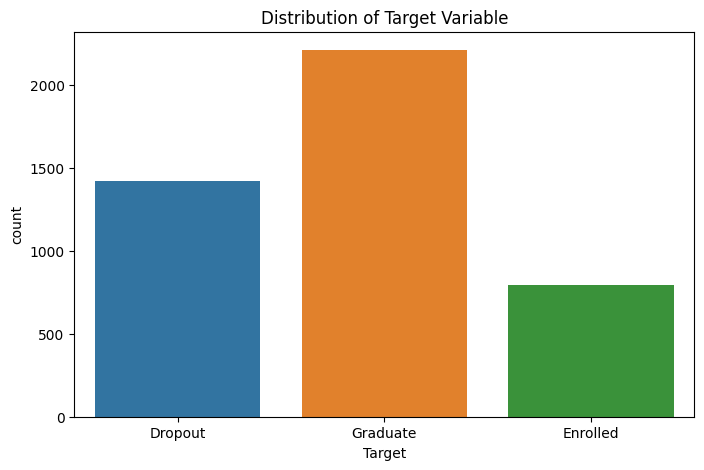

In [180]:
# plot the distribution of target variable
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Target")
plt.title("Distribution of Target Variable")
plt.show()

In [181]:
# Plotting histograms for each column in the dataset

'''

num_columns = len(df.columns)
plt.figure(figsize=(20, 4 * num_columns))

for i, col in enumerate(df.columns, 1):
    plt.subplot(num_columns, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()


for col in df.columns:
    length = len(df[col].unique())
    #if (length < 10):
    print(col,":", length)

'''

'\n\nnum_columns = len(df.columns)\nplt.figure(figsize=(20, 4 * num_columns))\n\nfor i, col in enumerate(df.columns, 1):\n    plt.subplot(num_columns, 3, i)\n    sns.histplot(df[col], bins=30, kde=True)\n    plt.title(f\'Distribution of {col}\')\n    plt.tight_layout()\n\nplt.show()\n\n\nfor col in df.columns:\n    length = len(df[col].unique())\n    #if (length < 10):\n    print(col,":", length)\n\n'

Features
Name, type, unique count or range

Marital Status - Categorical - 6
Application Mode - Categorical - 18
Application Order - Continuous - 0 to 10
Course - Categorical - 17
Daytime/evening attendance - binary - 2
Previous qualifications - Categorical - 17

In [182]:
from sklearn.model_selection import cross_val_score

def encode_target(x):
    if x == "Graduate":
        return 1
    elif x == "Dropout":
        return 0
    else:
        return x

df = df[df['Target'].isin(['Dropout', 'Graduate'])]

prepared_df = pd.DataFrame()

# one hot encoding for categorical variables with small number of unique values
# 7594 with all of these from 
one_hot_app_mode = pd.get_dummies(df['Application mode'], prefix='Application mode')
one_hot_encoded_marital = pd.get_dummies(df['Marital status'], prefix='Marital status')
one_hot_encoded_mother_qual = pd.get_dummies(df["Mother's qualification"], prefix="Mother's qualification")
one_hot_encoded_father_qual = pd.get_dummies(df["Father's qualification"], prefix="Father's qualification")
one_hot_encoded_mother_occ = pd.get_dummies(df["Mother's occupation"], prefix="Mother's occupation")
one_hot_encoded_father_occ = pd.get_dummies(df["Father's occupation"], prefix="Father's occupation")
one_hot_encoded_nationality = pd.get_dummies(df["Nacionality"], prefix="Nacionality")

prepared_df = pd.concat([prepared_df, one_hot_encoded_marital, one_hot_encoded_mother_qual, one_hot_encoded_father_qual, one_hot_encoded_mother_occ, one_hot_encoded_father_occ, one_hot_encoded_nationality], axis=1)

# ordinal variables
ordinal_column_names = ['Application order']
prepared_df = pd.concat([prepared_df, df[ordinal_column_names]], axis=1)

# binary variables
binary_column_names = ['Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
prepared_df = pd.concat([prepared_df, df[binary_column_names]], axis=1)

# continuous variables
continuous_column_names = ['Admission grade', 'Age at enrollment', 'Unemployment rate', 'Inflation rate', 'GDP']
prepared_df = pd.concat([prepared_df, df[continuous_column_names]], axis=1)

curricular_units_cols = [col for col in df.columns if col.startswith("Curricular units")]
prepared_df = pd.concat([prepared_df, df[curricular_units_cols]], axis=1)

# encoding the target column
df_target = df['Target'].apply(encode_target)
# print(df_target)

x = prepared_df
y = df_target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print("Training and testing data shape", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print("Total Columns: ", len(prepared_df.columns))


Training and testing data shape (2541, 185) (1089, 185) (2541,) (1089,)
Total Columns:  185


In [183]:
correlation_matrix = prepared_df.corr()

# flatten the correlation matrix
correlation_df = correlation_matrix.unstack().reset_index()

correlation_df.columns = ['Variable_1', 'Variable_2', 'Correlation']

# sort the DataFrame on the absolute value of the correlation
correlation_df['Abs_Correlation'] = correlation_df['Correlation'].abs()

# remove correlation of variables with themselves
correlation_df = correlation_df[correlation_df['Variable_1'] != correlation_df['Variable_2']]

# remove duplicates
correlation_df[['Variable_1', 'Variable_2']] = np.sort(correlation_df[['Variable_1', 'Variable_2']], axis=1)
correlation_df = correlation_df.drop_duplicates(subset=['Variable_1', 'Variable_2'])

# find high correlation
high_corr_pairs = correlation_df[correlation_df['Correlation'].abs() > 0.7]

# find columns names to drop
variables_to_drop = set()
for _, row in high_corr_pairs.iterrows():
    if row['Variable_1'] not in variables_to_drop and row['Variable_2'] not in variables_to_drop:
        variables_to_drop.add(row['Variable_1'])

prepared_df_filtered = prepared_df.drop(columns=variables_to_drop)

print("Total Columns after removing highly correlated columns: ", len(prepared_df_filtered.columns))

Total Columns after removing highly correlated columns:  167


### Logistic Regression All Data

In [184]:
model = LogisticRegression()

model.fit(x_train, y_train)

print("score: ", model.score(x_test, y_test))

# find proportion in test set
class_proportions = y_test.value_counts(normalize=True)
baseline_accuracy = class_proportions.max()
print("Baseline accuracy:", baseline_accuracy)

scores = cross_val_score(model, x, y, cv=10)

# Print the accuracy for each fold
print("Accuracy for each fold:")
print(scores)

#for feature, coef in zip(x_train.columns, model.coef_[0]):
#    print(feature, coef)

score:  0.9118457300275482
Baseline accuracy: 0.6198347107438017
Accuracy for each fold:
[0.91184573 0.92286501 0.89807163 0.90358127 0.90909091 0.90082645
 0.87878788 0.91735537 0.90909091 0.89807163]


### Logistic Regression with multicollinearity removed

In [185]:
x_filtered = prepared_df_filtered

x_train, x_test, y_train, y_test = train_test_split(x_filtered, y, test_size=0.3, random_state=42)

model = LogisticRegression()

model.fit(x_train, y_train)

print("score: ", model.score(x_test, y_test))

# find proportion in test set
class_proportions = y_test.value_counts(normalize=True)
baseline_accuracy = class_proportions.max()
print("Baseline accuracy:", baseline_accuracy)

scores = cross_val_score(model, x, y, cv=10)

# Print the accuracy for each fold
print("Accuracy for each fold:")
print(scores)

#for feature, coef in zip(x_train.columns, model.coef_[0]):
#    print(feature, coef)

score:  0.859504132231405
Baseline accuracy: 0.6198347107438017
Accuracy for each fold:
[0.91184573 0.92286501 0.89807163 0.90358127 0.90909091 0.90082645
 0.87878788 0.91735537 0.90909091 0.89807163]


### Logistic Regression Model Summary

In [186]:
x_train_const = sm.add_constant(x_train)

bool_cols = x_train_const.select_dtypes(include=['bool']).columns
x_train_const[bool_cols] = x_train_const[bool_cols].astype(int)

# Fit the logistic regression model
model_sm_filtered = sm.Logit(y_train, x_train_const).fit()

# View the summary of the model
print(model_sm_filtered.summary())

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
# Things we could try - decision tree, SVM (Support Vector Model), Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

modelRandomForestClassifier = RandomForestClassifier()
modelRandomForestClassifier.fit(x_train, y_train)

print(modelRandomForestClassifier.score(x_test, y_test))


0.8705234159779615


In [ ]:
from sklearn.tree import DecisionTreeClassifier
modelDecisionTree = DecisionTreeClassifier()
modelDecisionTree.fit(x_train, y_train)

print(modelDecisionTree.score(x_test, y_test))

0.8034894398530762


In [ ]:
from sklearn import svm
modelSVM = svm.SVC()
modelSVM.fit(x_train, y_train)

print(modelSVM.score(x_test, y_test))

0.7897153351698806
